In [17]:
%matplotlib inline
import holoviews as hv
hv.notebook_extension()
import sympy.interactive
sympy.interactive.init_printing('mathjax')
import sys
sys.path.append('/home/bnijholt/orbitalfield/')

In [18]:
import os
from scripts.hpc05 import HPC05Client
os.environ['SSH_AUTH_SOCK'] = os.path.join(os.path.expanduser('~'), 'ssh-agent.socket')
client = HPC05Client()

In [19]:
# from ipyparallel import Client
# client = Client(profile='python3')
dview = client[:]
lview = client.load_balanced_view()
len(dview)

In [37]:
%%px --local

import kwant
from types import SimpleNamespace
import sympy
from sympy.physics.quantum import TensorProduct as kr
import numpy as np
from scipy.constants import hbar, m_e, eV, physical_constants
from discretizer import Discretizer, momentum_operators
import scipy.optimize
from itertools import product
k_B = physical_constants['Boltzmann constant in eV/K'][0] * 1000
sx, sy, sz = [sympy.physics.matrices.msigma(i) for i in range(1, 4)]
s0 = sympy.eye(2)
s0 = sympy.eye(2)
s0sz = np.kron(s0, sz)
s0s0 = np.kron(s0, s0)

# Parameters taken from arXiv:1204.2792
# All constant parameters, mostly fundamental constants, in a SimpleNamespace.
constants = SimpleNamespace(
    m=0.015 * m_e,  # effective mass in kg
    a=10,  # lattice spacing in nm
    g=50,  # Lande factor
    hbar=hbar,
    m_e=m_e,
    e=eV,
    eV=eV,
    meV=eV * 1e-3)

constants.t = (hbar ** 2 / (2 * constants.m)) * (1e18 / constants.meV)  # meV * nm^2
constants.mu_B = physical_constants['Bohr magneton'][0] / constants.meV


def make_params(alpha=20,
                B_x=0,
                B_y=0,
                B_z=0,
                Delta=0.25,
                mu=0,
                orbital=True,
                t=constants.t,
                g=constants.g,
                mu_B=constants.mu_B,
                V=lambda x,y,z: 0,
                **kwargs):
    """Function that creates a namespace with parameters.

    Parameters:
    -----------
    alpha : float
        Spin-orbit coupling strength in units of meV*nm.
    B_x, B_y, B_z : float
        The magnetic field strength in the x, y and z direction in units of Tesla.
    Delta : float
        The superconducting gap in units of meV.
    mu : float
        The chemical potential in units of meV.
    orbital : bool
        Switches the orbital effects on and off.
    t : float
        Hopping parameter in meV * nm^2.
    g : float
        Lande g factor.
    mu_B : float
        Bohr magneton in meV/K.
    V : function
        Function of spatial coordinates (x, y, z) with is added to mu.

    Returns:
    --------
    p : SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    """
    p = SimpleNamespace(t=t,
                        g=g,
                        mu_B=mu_B,
                        alpha=alpha,
                        B_x=B_x,
                        B_y=B_y,
                        B_z=B_z,
                        Delta=Delta,
                        mu=mu,
                        orbital=orbital,
                        V=V,
                        **kwargs)
    return p


def cylinder_sector(r1, r2=0, L=1, L0=0, phi=360, angle=0, a=10):
    phi *= np.pi / 360
    angle *= np.pi / 180
    r1sq, r2sq = r1 ** 2, r2 ** 2
    def sector(pos):
        x, y, z = pos
        n = (y + 1j * z) * np.exp(1j * angle)
        y, z = n.real, n.imag
        rsq = y ** 2 + z ** 2
        return r2sq <= rsq < r1sq and z >= np.cos(phi) * np.sqrt(rsq) and L0 <= x < L
    r_mid = (r1 + r2) / 2
    return sector, (L - a, r_mid * np.sin(angle), r_mid * np.cos(angle))


def at_interface(site1, site2, shape1, shape2):
    return (shape1[0](site1.pos) and shape2[0](site2.pos)) or (shape2[0](site1.pos) and shape1[0](site2.pos))


def discretized_hamiltonian(a=10):
    k_x, k_y, k_z = momentum_operators
    t, B_x, B_y, B_z, mu_B, Delta, mu, alpha, g, V = sympy.symbols('t B_x B_y B_z mu_B Delta mu alpha g V', real=True)
    t_interface = sympy.symbols('t_interface', real=True)
    k = sympy.sqrt(k_x**2+k_y**2+k_z**2)
    
    ham = ((t * k**2 - mu - V) * kr(s0, sz) +
               alpha * (k_y * kr(sx, sz) - k_x * kr(sy, sz)) +
               0.5 * g * mu_B * (B_x * kr(sx, s0) + B_y * kr(sy, s0) + B_z * kr(sz, s0)) +
               Delta * kr(s0, sx))
        
    args = dict(space_dependent={'V'}, lattice_constant=a, discrete_coordinates={'x', 'y', 'z'})

    tb_normal = Discretizer(ham.subs(Delta, 0), **args)
    tb_sc = Discretizer(ham.subs(g, 0), **args)
    tb_interface = Discretizer(ham.subs(t, t_interface), **args)
    return tb_normal, tb_sc, tb_interface


def make_3d_wire(a=10, L=50, r1=50, r2=70, phi=135, angle=0):
    tb_normal, tb_sc, tb_interface = discretized_hamiltonian(a)
    lat = tb_normal.lattice
    syst = kwant.Builder()
    
    shape_normal = cylinder_sector(r1=r1, angle=angle, L=L, a=a)
    syst[lat.shape(*shape_normal)] = tb_normal.onsite
    
    shape_sc = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L=a, a=a)
    shape_sc2 = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L0=L-a, L=L, a=a)
    
    for shape in [shape_sc, shape_sc2]:
        syst[lat.shape(*shape)] = tb_sc.onsite

    def peierls(val, ind):
        def phase(s1, s2, p):
            x, y, z = s1.pos
            A_site = [p.B_y * z - p.B_z * y, 0, p.B_x * y][ind]
            A_site *= a * 1e-18 * eV / hbar
            return np.cos(A_site) * s0s0 - 1j * np.sin(A_site) * s0sz

        def with_phase(s1, s2, p):
            if p.orbital:
                return phase(s1, s2, p).dot(val(s1, s2, p))
            else:
                return val(s1, s2, p)
        return with_phase

    for hop, val in tb_normal.hoppings.items():
        ind = np.argmax(hop.delta)
        syst[hop] = peierls(val, ind)
    
    def cut(x_cut):
        sites = [lat(x, y, z) for x, y, z in [i.tag for i in syst.sites()] if x == x_cut]
        return sorted(sites, key=lambda s: s.pos[2]*1000 + s.pos[1])  
    
    l_cut = cut(1)
    r_cut = cut(2)
    
    num_orbs = 4
    dim = num_orbs * (len(l_cut) + len(r_cut))
    vlead = kwant.builder.SelfEnergyLead(lambda energy, args: np.zeros((dim, dim)), r_cut + l_cut)
    syst.leads.append(vlead)
    
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)))
    
    shape_normal_lead = cylinder_sector(r1=r1, angle=angle, L=a, a=a)
    lead[lat.shape(*shape_normal_lead)] = tb_normal.onsite
    lead[lat.shape(*shape_sc)] = tb_sc.onsite
    
    for hop, val in tb_sc.hoppings.items():
        ind = np.argmax(hop.delta)
        lead[hop] = peierls(val, ind)

    for hop, val in tb_interface.hoppings.items():
        ind = np.argmax(hop.delta)
        for part, shape1, shape2 in [(syst, shape_sc, shape_normal), 
                                     (syst, shape_sc2, shape_normal), 
                                     (lead, shape_sc, shape_normal_lead)]:
            hoppingkind = kwant.builder.HoppingKind(hop.delta, lat)(part)
            hopping_iterator = ((i, j) for (i, j) in hoppingkind if at_interface(i, j, shape1, shape2))
            part[hopping_iterator] = val#peierls(val, ind)  
        
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    
    syst = syst.finalized()

    r_cut_sites = [syst.sites.index(site) for site in r_cut]
    l_cut_sites = [syst.sites.index(site) for site in l_cut]
    
    def hopping(syst, args=()):
        return syst.hamiltonian_submatrix(args=args,
                                          to_sites=l_cut_sites,
                                          from_sites=r_cut_sites)[::2, ::2]
    return syst, hopping


def matsubara_frequency(T, n):
    return (2*n + 1) * np.pi * T * 1j


def null_H(syst, p, T, n):
    en = matsubara_frequency(T, n)
    gf = kwant.greens_function(syst, en, [p], [0], [0], check_hermiticity=False)
    return np.linalg.inv(gf.data[::2, ::2])


def gf_from_H_0(H_0, t):
    H = np.copy(H_0)
    dim = t.shape[0]
    H[:dim, dim:] -= t.T.conj()
    H[dim:, :dim] -= t
    return np.linalg.inv(H)


def current_from_H_0(T, H_0s, H12, phase):
    t = H12 * np.exp(1j * phase)
    I = 0
    for H_0 in H_0s:
        gf = gf_from_H_0(H_0, t - H12)
        dim = t.shape[0]
        H12G21 = t.T.conj() @ gf[dim:, :dim]
        H21G12 = t @ gf[:dim, dim:]
        I += -4 * T * (np.trace(H21G12) - np.trace(H12G21)).imag
    return I


def null_Hs(syst, p, T, n, B):
    (p.B_x, p.B_y, p.B_z) = B
    return null_H(syst, p, T, n)


T = 60e-3
matsfreqs = 20
syst, hopping = make_3d_wire(a=5, r1=50, r2=70)
p = make_params(Delta=60, alpha=20, mu=15, B_x=1, B_y=0, t_interface=constants.t)

b':Path   [x,y]'
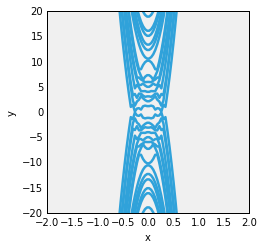

In [38]:
%%opts Path [aspect='square']
bands = kwant.physics.Bands(syst.leads[1], args=[p])
ks = np.linspace(-2, 2, 100)
en = np.array([bands(k=k) for k in ks])
hv.Path((ks, en))[:, -20:20]

In [22]:
Bs = np.linspace(0, 1, 50)
H_0s = lview.map_async(lambda x: null_Hs(syst, p, T, x[1], (x[0], 0, 0)), product(Bs, range(matsfreqs)))
H_0s.wait_interactive()
H_0s = np.array(H_0s.result())
H_0s = H_0s.reshape(-1, matsfreqs, *H_0s.shape[1:])

1000/1000 tasks finished after  119 s
done


In [27]:
def I_c(syst, p, T, H_0s):
    H12 = hopping(syst, [p])
    return scipy.optimize.minimize_scalar(lambda phase: -current_from_H_0(T, H_0s, H12, phase), 
                                          bounds=(-np.pi, np.pi), method='bounded')
 

I_cs = [I_c(syst, p, T, H_0s_) for p.B_x, H_0s_ in zip(Bs, H_0s)]

:Overlay
   .Curve.A_10_nm :Curve   [$B_x$]   ($I_c$)
   .Curve.A_5_nm  :Curve   [$B_x$]   ($I_c$)
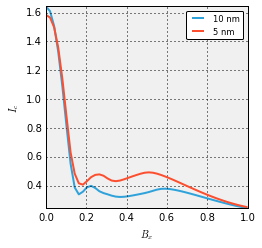

In [36]:
%%opts Overlay [show_legend=True] Curve [show_legend=True]
(hv.Curve((Bs, np.array([-I['fun'] for I in I_cs])), kdims=['$B_x$'], vdims=['$I_c$'], label='10 nm') 
 * hv.Curve((Bs, np.loadtxt('5nm.dat')), kdims=['$B_x$'], vdims=['$I_c$'], label='5 nm'))

In [ ]:
kwant.plot(syst)